**Notebook 2: análisis exploratorio de datos**

Objetivo: Realizar análisis exploratorio de datos (EDA)

# Inicialización

In [1]:
import pandas as pd
import os 
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
#nltk.download('punkt')
import spacy
from spacy import displacy
from collections import Counter
#!python -m spacy download es_core_news_md
nlp = spacy.load('es_core_news_md')
# Funciones propias para análisis
from herramientas_pme import *

In [2]:
# Directorios [cambiar a directorio propios]
pme_path = r'C:\Users\JoaquinFarina\Dropbox\Team NLP\Data\Planes de Mejoramiento Educativo\InformeFinal'
# establecer directorio de trabajo
os.chdir(pme_path)

In [3]:
agno_inicial = 2018
agno_final = 2022
agno_intervalo = range(agno_inicial, agno_final+1)

## Carga datos PME y adicionales

In [4]:
df_planificacion_implementacion_total = pd.read_csv('Datos\Intermedios\df_planificacion_implementacion_total_2018_2022.csv', 
                                                    low_memory=False)

In [5]:
columnas_bbdd_adicionales = ['rural_rbd', 'básica_adultos','básica_niños', 'media_hc_adultos', 'media_hc_jóvenes',
                             'media_tp_y_artística_adultos', 'media_tp_y_artística_jóvenes', 'parvularia', 'parvularia_ind', 
                             'básica_niños_ind', 'media_hc_jóvenes_ind', 'media_tp_y_artística_jóvenes_ind',
                             'básica_adultos_ind', 'media_hc_adultos_ind', 'media_tp_y_artística_adultos_ind', 
                             'total_niveles', 'total_matricula', 'asistencia', 'prioritario_alu',
                             'idps_am', 'idps_cc', 'idps_hv', 'idps_pf',
                             'prom_idps', 'prom_lect', 'prom_mate',
                             'prom_mate_lect','n_docentes','horas_contrato', 'horas_direct','horas_tec_ped',
                             'horas_aula','ano_servicio_sistema','ano_servicio_ee']

In [10]:
df_planificacion_implementacion_total[['nombre_actividad', 'dimensión', 'objetivo', 'estrategia', 'descripción_del_plan']].sample(8).to_excel('example_accionesPME.xlsx')

## Definir Planificación Anual

In [6]:
# recupertar sólo df de planificación anual
df_planificacion_total = df_planificacion_implementacion_total[df_planificacion_implementacion_total.en_planificacion_anual == 1]

# seleccionar columnas 
df_planificacion_total = df_planificacion_total[['id_accion','agno', 'rbd', 'region', 'deprov', 'comuna', 'dependencia',
                                                'nombre_actividad', 'en_planificacion_anual', 'dimensión',
                                                'subdimensión', 'objetivo', 'estrategia', 'descripción_del_plan',
                                                 'descripción_del_plan_norm', 'fecha_inicio', 'fecha_término', 
                                                 'programa_asociado','nombre_responsable', 'ate', 
                                                 'planes'] + columnas_bbdd_adicionales]

## Definir Reporte implementación

In [7]:
# recupertar sólo df de reporte implementación
df_implementacion_total = df_planificacion_implementacion_total[df_planificacion_implementacion_total.en_reporte_implementacion == 1]
   
# seleccionar columnas 
df_implementacion_total = df_implementacion_total[['id_accion','agno', 'rbd', 'region', 'deprov', 'comuna', 'dependencia',
                                                'nombre_actividad', 'en_reporte_implementacion', 'dimensión',
                                                'subdimensión', 'objetivo', 'estrategia', 'descripción_del_plan',
                                                'fecha_inicio', 'fecha_término', 'programa_asociado',
                                                'nombre_responsable', 'ate', 'planes', 'monto_subvencion_general', 
                                                'monto_sep', 'monto_pie','en_planificacion_anual',
                                                'monto_mantenimiento', 'monto_pro_retencion', 'monto_internado',
                                                'monto_reforzamiento', 'monto_feap', 'monto_aporte_municipal',
                                                'monto_total', 'nombre_nivel_ejecucion',
                                                'nombre_justificacion_nivel_ejecucion'] + columnas_bbdd_adicionales]

# Análisis BBDD1: Planificación Anual

In [8]:
# diccionarioa para guardar tablas
df_dict = {}

## Acciones por RBD

In [9]:
for a in agno_intervalo:
    if a == agno_inicial:
        df_resumen = df_planificacion_total[df_planificacion_total.agno == a].rbd.value_counts().describe()
    else:
        s2 = df_planificacion_total[df_planificacion_total.agno == a].rbd.value_counts().describe()
        df_resumen = pd.concat([df_resumen,s2], axis = 1)

df_resumen.columns = agno_intervalo
df_dict['total_acciones'] = np.round(df_resumen,2)

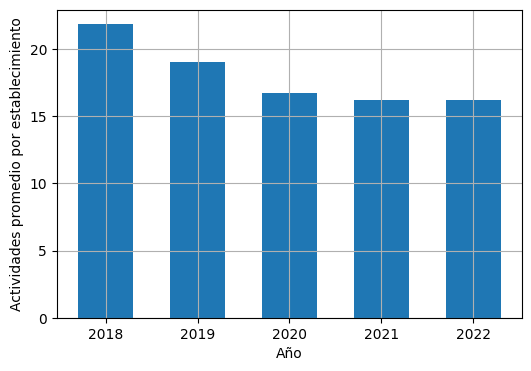

In [10]:
fig, ax = plt.subplots(figsize= (6,4))
ax.bar(agno_intervalo,df_resumen.loc['mean'],width = 0.6)
ax.set_xticks(agno_intervalo)
plt.ylabel("Actividades promedio por establecimiento")
plt.xlabel('Año')
plt.grid(True)
plt.savefig(r'Figuras\F1_resumen_total.png',dpi=200,bbox_inches='tight', 
               transparent=True,
               pad_inches=0)
plt.show()

In [11]:
np.round(df_resumen,2)

,2018,2019,2020,2021,2022
count,8590.00,8621.00,8727.00,8788.00,8585.00
mean,21.83,19.00,16.71,16.18,16.17
std,11.08,10.15,8.95,8.87,8.70
min,6.00,2.00,2.00,4.00,1.00
25%,14.00,11.00,10.00,10.00,10.00
50%,20.00,17.00,15.00,14.00,14.00
75%,28.00,24.00,21.00,20.00,20.00
max,121.00,124.00,139.00,150.00,185.00


## Acciones por Región y DEPROV

In [12]:
for a in agno_intervalo:
    if a == agno_inicial:
        df_region_deprov = df_planificacion_total[df_planificacion_total.agno == a][['region','deprov','rbd']].groupby(['region','deprov']).apply(columnas_agregacion)
        df_region_deprov.columns = [x +'_{}'.format(a) for x in df_region_deprov.columns]
    else:
        s2 = df_planificacion_total[df_planificacion_total.agno == a][['region','deprov','rbd']].groupby(['region','deprov']).apply(columnas_agregacion)
        s2.columns = [x +'_{}'.format(a) for x in s2.columns]
        df_region_deprov = pd.concat([df_region_deprov,s2], axis = 1)
        
# save
df_dict['region_deprov'] = df_region_deprov

In [13]:
df_region_deprov

Actividades por EE_2018  \
region                                       deprov                                                                        
DE ANTOFAGASTA                               Antofagasta                                                            21.6   
                                             El Loa                                                                 19.1   
DE ARICA Y PARINACOTA                        Arica                                                                  23.4   
                                             Parinacota                                                              9.2   
DE ATACAMA                                   Copiapo - Chanaral                                                     23.7   
                                             Huasco - Vallenar                                                      19.2   
DE AYSÉN DEL GENERAL CARLOS IBAÑEZ DEL CAMPO Coyhaique                                                              25.7   
DE COQUIMBO                                  Choapa                                                                 20.7   
                                             Elqui                                                                  22.2   
                                             Limari                                                                 17.7   
DE LA ARAUCANÍA                              Cautin Norte                                                           22.4   
                                             Cautin Sur                                                             18.2   
                                             Malleco                                                                20.5   
DE LOS LAGOS                                 Chiloe                                                                 20.6   
                                             Llanquihue                                                             16.0   
                                             Osorno                                                                 22.1   
                                             Palena                                                                 22.1   
DE LOS RÍOS                                  Ranco                                                                  20.1   
                                             Valdivia                                                               21.3   
DE MAGALLANES Y DE LA ANTÁRTICA CHILENA      Magallanes                                                             21.6   
DE TARAPACÁ                                  Iquique                                                                22.9   
                                             Tamarugal                                                              18.9   
DE VALPARAÍSO                                Quillota - Petorca                                                     18.6   
                                             San Antonio                                                            26.2   
                                             San Felipe - Los Andes                                                 25.0   
                                             Valparaiso - Isla de Pascua                                            24.1   
DE ÑUBLE                                     Diguillín                                                              13.9   
DEL BIOBÍO                                   Arauco                                                                 17.5   
                                             Bio Bio                                                                21.6   
                                             Concepcion                                                             22.9   
DEL LIBERTADOR BERNARDO OHIGGINS             Cachapoal                                                              18.4   
     

## Acciones por dependencia

In [14]:
for a in agno_intervalo:
    if a == agno_inicial:
        df_depe = df_planificacion_total[df_planificacion_total.agno == a][['dependencia','rbd']].groupby(['dependencia']).apply(columnas_agregacion)
        df_depe.columns = [str(a) for x in df_depe.columns]
    else:
        s2 = df_planificacion_total[df_planificacion_total.agno == a][['dependencia','rbd']].groupby(['dependencia']).apply(columnas_agregacion)
        s2.columns = [str(a) for x in s2.columns]
        df_depe = pd.concat([df_depe,s2], axis = 1)
        
# save
df_dict['dependencia'] = df_depe

In [15]:
df_depe

,2018,2019,2020,2021,2022
dependencia,,,,,
Corporación Municipal,24.0,21.0,17.6,17.8,18.0
Corporación Privada o de administración delegada,17.9,18.0,16.8,15.3,15.0
Municipal DAEM,20.4,17.2,14.7,14.3,14.3
Particular Subvencionado,23.2,20.7,18.7,17.8,17.8
Servicio locales de Educacion,19.1,16.5,14.6,14.1,14.1


## Acciones por total niveles EE 

In [16]:
df_tot_niveles = calcular_acciones_por_EE_variable(df_planificacion_total, 'total_niveles')
# save
df_dict['niveles'] = df_tot_niveles
df_tot_niveles

,2018,2019,2020,2021,2022
total_niveles,,,,,
1.0,16.9,14.3,13.0,12.4,12.3
2.0,23.6,20.7,17.7,17.1,17.1
3.0,27.0,24.0,21.2,20.8,20.7
4.0,27.3,22.9,20.9,20.8,20.6
5.0,28.3,26.3,22.6,21.6,21.2
6.0,30.1,27.4,22.4,30.5,26.2
7.0,31.5,22.7,19.0,18.3,21.3


## Actividades por tamaño de EE

In [17]:
# EE sin matrícula con PME: casi ninguno
pd.crosstab(df_planificacion_total[df_planificacion_total.total_matricula.isna()].rbd,df_planificacion_total[df_planificacion_total.total_matricula.isna()].agno)

agno,2018,2019,2020,2021,2022
rbd,,,,,
88,0,0,0,0,9
2609,0,0,0,8,0
4093,0,0,8,0,0
13215,0,0,18,0,0
16927,0,28,0,0,0
17837,0,0,0,0,8
20488,20,0,0,0,0
31001,0,0,0,0,8
42041,0,0,0,8,0


In [18]:
# generar variable de agrupamiento por tamaño 
bins = pd.IntervalIndex.from_tuples([(0, 100), (100, 250), (250, 500),(500,1000),(1000,5000)])
df_planificacion_total['total_matricula_grouped'] =  pd.cut(df_planificacion_total.total_matricula, 
                                                             bins,include_lowest=True, labels=[1,2,3,4,5])

In [19]:
df_tot_matricula = calcular_acciones_por_EE_variable(df_planificacion_total,'total_matricula_grouped')
# save
df_dict['matricula'] = df_tot_matricula

In [20]:
df_tot_matricula

,2018,2019,2020,2021,2022
total_matricula_grouped,,,,,
"(0, 100]",16.2,13.7,12.1,11.8,11.7
"(100, 250]",21.7,18.6,16.3,15.4,15.2
"(250, 500]",25.1,22.0,18.8,18.3,18.2
"(500, 1000]",27.5,24.4,21.4,20.8,20.7
"(1000, 5000]",30.2,27.5,24.9,24.4,24.4


## Acciones según ruralidad 

In [21]:
df_tot_rural = calcular_acciones_por_EE_variable(df_planificacion_total, 'rural_rbd')
# guardar
df_dict['ruralidad'] = df_tot_rural
df_tot_rural

,2018,2019,2020,2021,2022
rural_rbd,,,,,
0.0,24.5,21.7,19.1,18.4,18.3
1.0,17.6,14.7,12.7,12.3,12.3


## Fechas inicio y término acciones

In [22]:
df_planificacion_total['fecha_inicio_mes'] = pd.DatetimeIndex(df_planificacion_total['fecha_inicio']).month
df_planificacion_total['fecha_termino_mes'] = pd.DatetimeIndex(df_planificacion_total['fecha_término']).month

### Fecha inicio

In [23]:
df_resumen_fecha_inicio = calcular_acciones_por_EE_fecha(df_planificacion_total, 'fecha_inicio_mes')
# guardar
df_dict['fecha_inicio'] = df_resumen_fecha_inicio
df_resumen_fecha_inicio

,2018,2019,2020,2021,2022
enero,8.18,9.18,9.33,9.93,9.46
febrero,1.63,1.55,1.24,1.42,1.23
marzo,56.55,60.16,57.00,65.82,64.99
abril,11.80,9.05,9.57,8.05,8.70
mayo,3.89,4.64,4.66,4.72,5.58
junio,5.48,6.24,3.43,5.03,5.00
julio,5.19,3.82,3.38,2.09,1.96
agosto,4.72,3.39,7.88,1.86,2.01
septiembre,0.84,0.66,1.88,0.37,0.34
octubre,0.61,0.46,0.79,0.24,0.29


### Fecha término

In [24]:
df_resumen_fecha_termino = calcular_acciones_por_EE_fecha(df_planificacion_total, 'fecha_termino_mes')
# guardar
df_dict['fecha_termino'] = df_resumen_fecha_termino
df_resumen_fecha_termino

,2018,2019,2020,2021,2022
enero,0.06,0.07,0.04,0.01,0.01
febrero,0.03,0.05,0.06,0.03,0.01
marzo,0.32,0.28,0.27,0.25,0.18
abril,0.47,0.37,0.21,0.28,0.23
mayo,0.41,0.76,0.21,0.45,0.46
junio,0.81,0.63,0.21,0.46,0.48
julio,0.86,0.80,0.42,0.51,0.51
agosto,0.96,0.80,1.04,0.47,0.48
septiembre,0.84,0.69,0.74,0.41,0.42
octubre,1.80,1.60,0.87,0.64,0.77


### Duración actividad

In [25]:
df_planificacion_total['fecha_inicio'] = pd.to_datetime(df_planificacion_total['fecha_inicio'])
df_planificacion_total['fecha_término'] = pd.to_datetime(df_planificacion_total['fecha_término'])
df_planificacion_total['fecha_duracion_meses'] = (df_planificacion_total['fecha_término'] - df_planificacion_total['fecha_inicio']).dt.days/30

In [26]:
for a in agno_intervalo:
    if a == agno_inicial:
        df_resumen_duracion = df_planificacion_total[df_planificacion_total.agno == a].fecha_duracion_meses.describe()
    else:
        s2 = df_planificacion_total[df_planificacion_total.agno == a].fecha_duracion_meses.describe()
        df_resumen_duracion = pd.concat([df_resumen_duracion,s2], axis = 1)

df_resumen_duracion.columns = agno_intervalo

In [27]:
# guardar
df_dict['duracion'] = np.round(df_resumen_duracion,2)
np.round(df_resumen_duracion,2)

,2018,2019,2020,2021,2022
count,187531.00,163842.00,145791.00,142213.00,138808.00
mean,8.50,8.70,8.73,9.26,9.19
std,2.63,2.51,2.56,2.13,2.14
min,0.03,0.03,0.03,0.03,0.03
25%,7.60,8.07,8.07,9.00,8.90
50%,9.37,9.50,9.70,10.07,10.03
75%,10.17,10.17,10.13,10.17,10.17
max,12.13,12.13,12.17,12.13,12.13


## Dimensión  PME                  

In [28]:
for a in agno_intervalo:
    data_a = df_planificacion_total[df_planificacion_total.agno == a]
   
    if a == agno_inicial:
        df_resumen_dimension = data_a['dimensión'].value_counts()/len(data_a.rbd.unique())
    else:
        s2 = data_a['dimensión'].value_counts()/len(data_a.rbd.unique())
        df_resumen_dimension = pd.concat([df_resumen_dimension,s2], axis = 1)

df_resumen_dimension.columns = agno_intervalo

In [29]:
# Acciones en dimensión por EE
df_dict['dimension'] = np.round(df_resumen_dimension,2)
np.round(df_resumen_dimension,2)

,2018,2019,2020,2021,2022
Gestión Pedagógica,6.70,5.87,4.87,4.78,4.81
Convivencia Escolar,5.40,4.68,3.92,3.78,3.88
Gestión de Recursos,5.21,4.55,4.39,4.19,4.06
Liderazgo,4.52,3.90,3.52,3.43,3.42


In [30]:
for a in agno_intervalo:
    data_a = df_planificacion_total[df_planificacion_total.agno == a][['rbd','dimensión']]
    
    for col in ['Convivencia Escolar', 'Gestión de Recursos', 'Gestión Pedagógica', 'Liderazgo']:
        data_a.loc[:,col] = 100*(data_a['dimensión'] == col).astype(int)
    
    if a == agno_inicial:
        df_resumen_dimesion_porc = np.round(data_a.groupby(['rbd']).mean().mean(),2)
    else:
        s2 = np.round(data_a.groupby(['rbd']).mean().mean(),2)
        df_resumen_dimesion_porc = pd.concat([df_resumen_dimesion_porc,s2], axis = 1)
        
df_resumen_dimesion_porc.columns = agno_intervalo

In [31]:
# promedio de % de acciones de dimensión por EE  
df_dict['dimension_distrib'] =  df_resumen_dimesion_porc
df_resumen_dimesion_porc

,2018,2019,2020,2021,2022
Convivencia Escolar,24.68,24.56,23.55,23.49,24.01
Gestión de Recursos,23.95,24.06,26.28,26.00,25.24
Gestión Pedagógica,30.08,30.11,28.33,28.61,28.98
Liderazgo,21.30,21.27,21.84,21.90,21.78


## Programa asociado

In [32]:
for a in agno_intervalo:
    data_a = df_planificacion_total[df_planificacion_total.agno == a]  
    
    if a == agno_inicial:
        df_resumen_programa = data_a['programa_asociado'].value_counts(dropna=False)/len(data_a)
    else:
        s2 = data_a['programa_asociado'].value_counts(dropna=False)/len(data_a)
        df_resumen_programa = pd.concat([df_resumen_programa,s2], axis = 1)

df_resumen_programa.columns = agno_intervalo

In [33]:
df_dict['programa'] =  np.round(100*df_resumen_programa,2)
np.round(100*df_resumen_programa,2)

,2018,2019,2020,2021,2022
SEP,85.88,85.30,82.51,71.18,68.39
Otro,8.08,8.94,9.03,5.21,4.32
PIE,3.30,3.06,3.08,2.93,2.80
Reforzamiento educativo,0.90,0.82,0.97,0.79,0.85
Enlaces,0.34,0.15,NaN,NaN,NaN
Rural,0.31,0.32,0.35,0.40,0.35
CRA,0.26,0.37,0.29,0.56,0.58
Fomento lector,0.23,0.24,0.18,0.34,0.43
Aula de bienestar,0.16,0.21,0.33,0.60,0.53
Actividad física,0.11,0.11,0.10,0.16,0.24


## Responsable

In [34]:
for a in agno_intervalo:
    data_a = df_planificacion_total[df_planificacion_total.agno == a]  
    
    if a == agno_inicial:
        df_resumen_respon = data_a['nombre_responsable'].value_counts(dropna=False)/len(data_a)
    else:
        s2 = data_a['nombre_responsable'].value_counts(dropna=False)/len(data_a)
        df_resumen_respon = pd.concat([df_resumen_respon,s2], axis = 1)

df_resumen_respon.columns = agno_intervalo

In [35]:
df_dict['responsable'] = np.round(100*df_resumen_respon,2)
np.round(100*df_resumen_respon,2)

,2018,2019,2020,2021,2022
Director,29.33,29.20,28.15,27.10,26.79
Equipo de gestión,20.03,19.97,20.55,20.12,19.52
Otro,12.01,12.00,12.24,13.11,13.29
Jefe técnico,11.26,11.71,10.72,10.76,11.57
Sostenedor,9.92,10.05,11.90,11.43,10.93
Docente,7.90,6.90,5.76,5.95,5.86
Encargado de convivencia,6.30,7.27,8.19,9.11,9.66
Orientador,1.50,1.26,1.15,1.07,1.05
Jefe de departamento,0.68,0.61,0.47,0.44,0.42
Encargado de ciclo,0.50,0.49,0.43,0.51,0.54


## ATE

In [36]:
for a in agno_intervalo:
    data_a = df_planificacion_total[df_planificacion_total.agno == a]  
    
    if a == agno_inicial:
        df_resumen_ate = data_a['ate'].value_counts(dropna=False)/len(data_a)
    else:
        s2 = data_a['ate'].value_counts(dropna=False)/len(data_a)
        df_resumen_ate = pd.concat([df_resumen_ate,s2], axis = 1)

df_resumen_ate.columns = agno_intervalo

In [37]:
df_dict['ate'] = np.round(100*df_resumen_ate,2)
np.round(100*df_resumen_ate,2)

,2018,2019,2020,2021,2022
No,92.66,92.35,93.91,93.64,93.39
Si,4.67,4.59,3.27,3.34,3.43
No Definido,2.66,3.06,2.82,3.02,3.17


## Dimensión y responsable

In [38]:
j = 0
for a in agno_intervalo:
    print(a)
    data = df_planificacion_total[df_planificacion_total.agno == a]
    df = pd.crosstab(data['nombre_responsable'], data['dimensión'], normalize ='columns')
    
    df.columns = [x + ' ' + str(a) for x in df.columns]
    
    if a == agno_inicial :
        df_tot = df.copy()
    else:
        df_tot = pd.concat([df_tot, df], axis = 1)
        
df_tot = np.round(100*df_tot,2)
df_tot = df_tot.reindex(sorted(df_tot.columns), axis=1)

2018
2019
2020
2021
2022


In [39]:
df_tot

,Convivencia Escolar 2018,Convivencia Escolar 2019,Convivencia Escolar 2020,Convivencia Escolar 2021,Convivencia Escolar 2022,Gestión Pedagógica 2018,Gestión Pedagógica 2019,Gestión Pedagógica 2020,Gestión Pedagógica 2021,Gestión Pedagógica 2022,Gestión de Recursos 2018,Gestión de Recursos 2019,Gestión de Recursos 2020,Gestión de Recursos 2021,Gestión de Recursos 2022,Liderazgo 2018,Liderazgo 2019,Liderazgo 2020,Liderazgo 2021,Liderazgo 2022
nombre_responsable,,,,,,,,,,,,,,,,,,,,
Director,21.41,20.07,16.96,15.04,15.14,19.23,17.97,16.83,15.55,14.59,36.87,37.83,35.64,35.07,35.25,45.04,46.99,46.89,46.73,47.13
Docente,8.97,7.70,6.40,6.46,6.13,10.81,9.95,9.12,9.63,9.53,5.27,4.34,3.27,3.17,3.14,5.34,4.35,3.53,3.65,3.64
Encargado de ciclo,0.41,0.24,0.22,0.25,0.23,0.95,1.08,1.04,1.26,1.33,0.22,0.20,0.15,0.12,0.13,0.24,0.24,0.17,0.21,0.26
Encargado de convivencia,23.12,27.67,32.68,36.74,38.22,0.77,0.53,0.72,0.76,0.56,0.61,0.54,0.54,0.50,0.52,0.94,0.78,0.78,0.79,0.90
Equipo de gestión,19.76,19.00,19.34,17.28,16.80,20.39,20.92,22.42,21.97,21.01,18.66,18.24,18.17,18.40,17.97,21.38,21.72,22.29,22.80,22.34
Jefe de departamento,0.64,0.56,0.45,0.42,0.33,1.15,1.03,0.82,0.80,0.76,0.43,0.42,0.31,0.29,0.31,0.28,0.26,0.17,0.16,0.19
Jefe de especialidad,0.34,0.28,0.26,0.20,0.17,0.72,0.62,0.52,0.48,0.48,0.34,0.31,0.23,0.22,0.22,0.17,0.21,0.21,0.19,0.16
Jefe técnico,2.94,2.51,1.87,1.51,1.60,27.01,29.51,29.93,30.63,32.67,5.04,4.26,3.10,2.64,2.86,5.05,4.65,3.55,3.19,3.58
Orientador,4.44,3.76,3.72,3.52,3.23,0.90,0.71,0.66,0.56,0.56,0.19,0.16,0.13,0.10,0.11,0.38,0.34,0.23,0.27,0.34


In [40]:
for col in ['Convivencia Escolar', 'Gestión de Recursos', 'Gestión Pedagógica', 'Liderazgo']:
    data = df_tot[[x for x in df_tot.columns if col in x]]
    data.columns = agno_intervalo
    df_dict['Responsable vs Dim. ' + col] = data

In [41]:
# eg: liderazgo
data

,2018,2019,2020,2021,2022
nombre_responsable,,,,,
Director,45.04,46.99,46.89,46.73,47.13
Docente,5.34,4.35,3.53,3.65,3.64
Encargado de ciclo,0.24,0.24,0.17,0.21,0.26
Encargado de convivencia,0.94,0.78,0.78,0.79,0.90
Equipo de gestión,21.38,21.72,22.29,22.80,22.34
Jefe de departamento,0.28,0.26,0.17,0.16,0.19
Jefe de especialidad,0.17,0.21,0.21,0.19,0.16
Jefe técnico,5.05,4.65,3.55,3.19,3.58
Orientador,0.38,0.34,0.23,0.27,0.34


## Planes

In [42]:
df_planes_split = df_planificacion_total.copy()
df_planes_split['planes'] = df_planes_split.planes.str.split(';')

In [43]:
# completar vacios con listas vacias
df_planes_split['planes'] = df_planes_split['planes'].apply(lambda d: d if isinstance(d, list) else [])
# caclcular largo 
df_planes_split['planes_largo'] = df_planes_split['planes'].apply(len)

In [44]:
# Completas listas con vacíos para que tengan el mismo largo 
l_max = 7
values_planes_tot = []
n_empty = 0
for ind, row in df_planes_split.iterrows():
    planes = row.planes
    l = len(planes)
    # eliminar espacio (" ") al inicio de strings
    planes = [x.lstrip() for x in planes]
    # completar hasta l_max con nulls
    add = [np.nan for x in range(l_max-l)]    
    values = planes + add
    values_planes_tot +=[ list(row.values) +  values]

In [45]:
# calcular valores únicos para planes
df_planificacion_total  = pd.DataFrame(values_planes_tot)
df_planificacion_total.columns = list(df_planes_split.columns) + ['plan_' + str(i) for i in range(1,8)] 
unicos_tot = set()
for col in ['plan_' + str(i) for i in range(1,8)]:
    print(col)
    unicos = df_planificacion_total[col].unique()
    unicos_tot = unicos_tot.union(set(unicos))

plan_1
plan_2
plan_3
plan_4
plan_5
plan_6
plan_7


In [46]:
unicos_tot

{'Ninguno',
 'Plan Integral de Seguridad Escolar',
 'Plan de Apoyo a la Inclusión',
 'Plan de Desarollo Profesional Docente',
 'Plan de Formación Ciudadana',
 'Plan de Gestión de la Convivencia Escolar',
 'Plan de Sexualidad, Afectividad y Género',
 nan}

In [47]:
# Generar columnas que indiquen para cada plan si está considerado en actividad
for plan in list(unicos_tot):
    print(plan)
    if str(plan) != 'nan':
        plan_norm = plan.replace(' ','_').replace(',','').lower() 
        df_planificacion_total[plan_norm + '_ind'] = ((df_planificacion_total.plan_1 == plan) |
                                                      (df_planificacion_total.plan_2 == plan) |
                                                      (df_planificacion_total.plan_3 == plan) |
                                                      (df_planificacion_total.plan_4 == plan) |
                                                      (df_planificacion_total.plan_5 == plan) |
                                                      (df_planificacion_total.plan_6 == plan) |
                                                      (df_planificacion_total.plan_7 == plan)    ).astype(int)

nan
Plan de Desarollo Profesional Docente
Plan de Gestión de la Convivencia Escolar
Plan Integral de Seguridad Escolar
Plan de Formación Ciudadana
Plan de Sexualidad, Afectividad y Género
Ninguno
Plan de Apoyo a la Inclusión


In [48]:
df_planificacion_total['total_planes'] = df_planificacion_total[['plan_de_desarollo_profesional_docente_ind', 
                                                          'plan_de_gestión_de_la_convivencia_escolar_ind', 
                                                          'plan_de_formación_ciudadana_ind', 
                                                          'plan_de_sexualidad_afectividad_y_género_ind',
                                                          'plan_de_apoyo_a_la_inclusión_ind', 
                                                          'plan_integral_de_seguridad_escolar_ind']].sum(axis=1)

In [49]:
df_planes = df_planificacion_total[['plan_de_desarollo_profesional_docente_ind', 
                                    'plan_de_gestión_de_la_convivencia_escolar_ind', 
                                    'ninguno_ind', 'plan_de_formación_ciudadana_ind', 
                                    'plan_de_apoyo_a_la_inclusión_ind', 
                                    'plan_integral_de_seguridad_escolar_ind',
                                    'plan_de_sexualidad_afectividad_y_género_ind',
                                    'agno']].groupby(['agno']).mean().T

df_dict['planes'] = np.round(100*df_planes,2)
np.round(100*df_planes,2)

agno,2018,2019,2020,2021,2022
plan_de_desarollo_profesional_docente_ind,32.18,36.78,36.95,38.02,38.68
plan_de_gestión_de_la_convivencia_escolar_ind,50.02,53.63,53.97,53.38,54.37
ninguno_ind,16.94,14.45,14.09,13.96,14.13
plan_de_formación_ciudadana_ind,18.42,20.29,16.71,16.53,18.18
plan_de_apoyo_a_la_inclusión_ind,47.13,50.65,49.47,49.47,49.77
plan_integral_de_seguridad_escolar_ind,16.58,19.48,27.12,26.60,25.21
plan_de_sexualidad_afectividad_y_género_ind,16.38,18.81,17.45,17.69,20.06


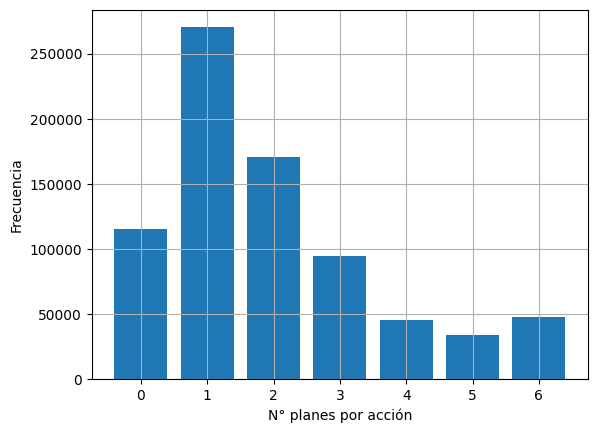

In [50]:
plt.bar(df_planificacion_total.total_planes.value_counts().index, df_planificacion_total.total_planes.value_counts().values)
plt.xlabel('N° planes por acción')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.savefig(r'Figuras\F2_planes_por_accion.png',dpi=200,bbox_inches='tight', 
               transparent=True,
               pad_inches=0)
plt.show()

In [51]:
# Promedio planes por acción
df_planes_totales = np.round(df_planificacion_total[['total_planes','agno']].groupby(['agno']).mean().T,2)
df_dict['planes_totales'] = df_planes_totales
df_planes_totales

agno,2018,2019,2020,2021,2022
total_planes,1.81,2.0,2.02,2.02,2.06


## Atributos linguisticos

### Cantidad de frases en Descripción del Plan

In [52]:
# Segmentación en frases 
df_planificacion_total['n_frases_descripcion_plan'] = df_planificacion_total['descripción_del_plan'].apply(n_frases)
df_planificacion_total['n_palabras_descripcion_plan'] = df_planificacion_total['descripción_del_plan'].apply(n_palabras)

In [53]:
for a in agno_intervalo:
    data_a = df_planificacion_total[df_planificacion_total.agno == a]  
    if a == agno_inicial:
        df_resumen_n_frases = data_a['n_frases_descripcion_plan'].value_counts(dropna=False)/len(data_a)
    else:
        s2 = data_a['n_frases_descripcion_plan'].value_counts(dropna=False)/len(data_a)
        df_resumen_n_frases = pd.concat([df_resumen_n_frases,s2], axis = 1)

df_resumen_n_frases.columns = agno_intervalo

In [54]:
df_resumen_n_frases = np.round(100*df_resumen_n_frases.iloc[:4],2)
df_dict['numero_de_frases'] = df_resumen_n_frases
df_resumen_n_frases

,2018,2019,2020,2021,2022
1.0,82.61,81.12,79.76,79.29,80.33
2.0,13.73,14.82,15.92,16.26,15.67
3.0,2.66,2.96,3.20,3.24,3.00
4.0,0.62,0.68,0.67,0.70,0.59


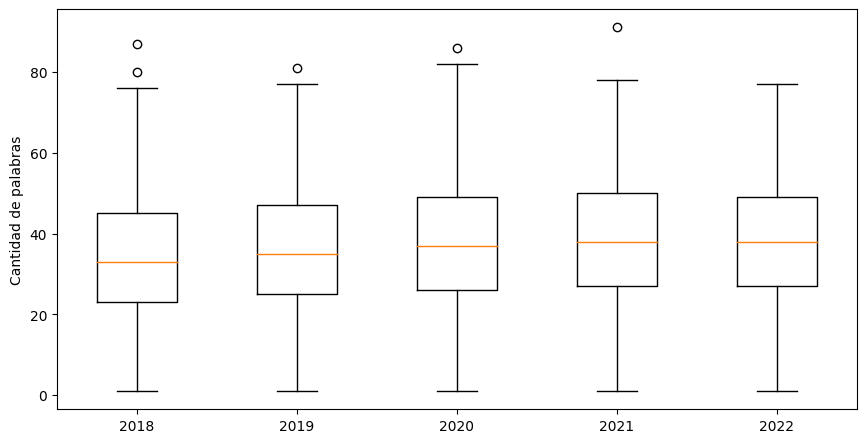

In [55]:
data_list = []
for a in agno_intervalo:
    data_list+= [df_planificacion_total[df_planificacion_total.agno==a].n_palabras_descripcion_plan.dropna()]
 

fig = plt.figure(figsize =(8, 4))
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data_list)

ax.set_ylabel('Cantidad de palabras')
ax.set_xticklabels(list(agno_intervalo))
# show plot
plt.savefig(r'Figuras\F3_cantidad_palabras.png',dpi=200,bbox_inches='tight', 
               transparent=True,
               pad_inches=0)
plt.show()

### Number of unique words

In [56]:
df_planificacion_total['n_palabras_unicas_descripcion_plan'] = df_planificacion_total['descripción_del_plan'].apply(n_palabras_unicas)

In [57]:
df_n_unique_words = np.round(df_planificacion_total[['agno', 
                                                     'n_palabras_unicas_descripcion_plan']].groupby(['agno']).mean().T,2)
df_dict['n_palabras_unicas'] = df_n_unique_words
df_n_unique_words

agno,2018,2019,2020,2021,2022
n_palabras_unicas_descripcion_plan,27.88,28.96,30.03,30.64,30.3


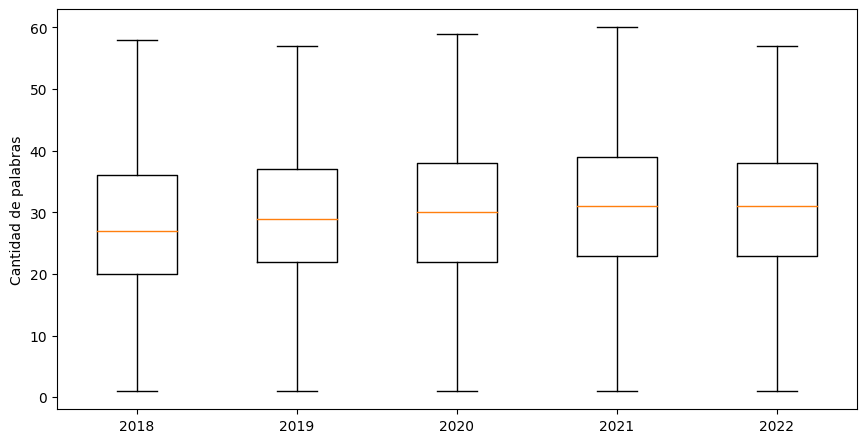

In [58]:
data_list = []
for a in agno_intervalo:
    data_list+= [df_planificacion_total[df_planificacion_total.agno==a].n_palabras_unicas_descripcion_plan.dropna()]
 

fig = plt.figure(figsize =(8, 4))
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data_list)

ax.set_ylabel('Cantidad de palabras')
ax.set_xticklabels(list(agno_intervalo))
# show plot
plt.savefig(r'Figuras\F4_cantidad_palabras_unicas.png',dpi=200,bbox_inches='tight', 
               transparent=True,
               pad_inches=0)
plt.show()

### Number of characters

In [59]:
df_planificacion_total['n_caracteres_descripcion_plan'] = df_planificacion_total['descripción_del_plan'].apply(n_caracteres)

In [60]:
df_n_caracteres = np.round(df_planificacion_total[['agno', 'n_caracteres_descripcion_plan']].groupby(['agno']).mean().T,2)
df_dict['n_caracteres'] = df_n_caracteres
df_n_caracteres

agno,2018,2019,2020,2021,2022
n_caracteres_descripcion_plan,234.08,245.67,255.79,262.57,260.88


### Word frequency

In [61]:
descripcion_fill_string = df_planificacion_total['descripción_del_plan'].to_string()
token=re.findall('\w+', descripcion_fill_string)
sw=nltk.corpus.stopwords.words('spanish')

In [62]:
words=[]
for word in token:
    words.append(word.lower())
# get the list without stop words
words_ne=[]
for word in words:
    if (word not in sw) and (len(word)>2):
        words_ne.append(word)

In [63]:
words_ne = list(map(lambda x: x.replace('realizara', 'realizar'), words_ne))
words_ne = list(map(lambda x: x.replace('realizará', 'realizar'), words_ne))
words_ne = list(map(lambda x: x.replace('realizarán', 'realizar'), words_ne))
words_ne = list(map(lambda x: x.replace('realiza', 'realizar'), words_ne))

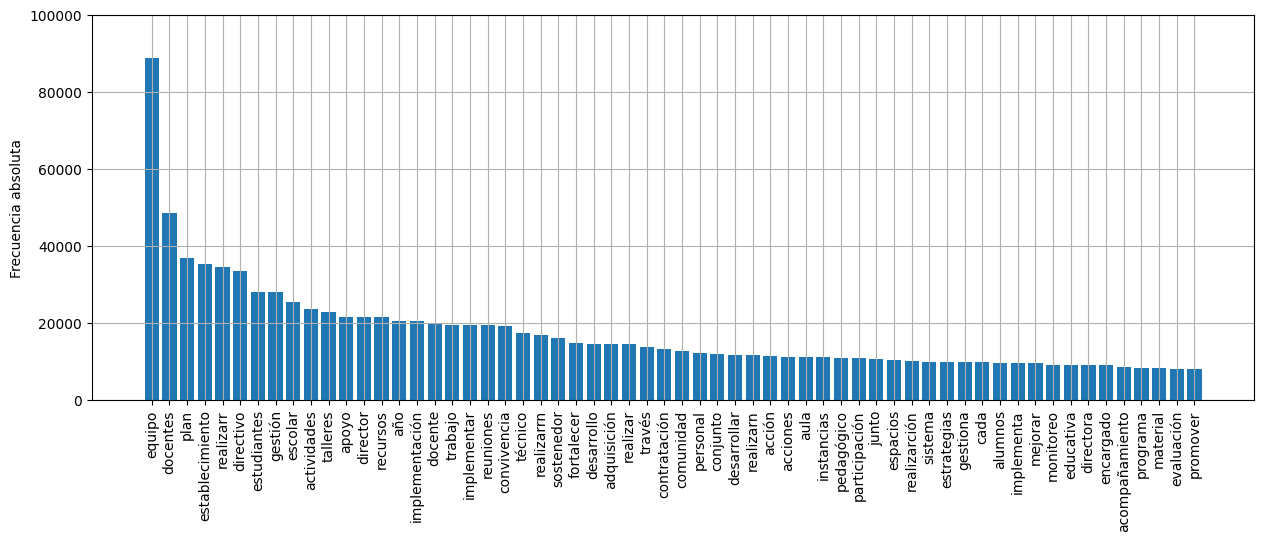

In [64]:
fig,ax = plt.subplots(figsize=(15,5))
nlp_words=nltk.FreqDist(words_ne)
df = pd.DataFrame(nlp_words.most_common(60), columns = ['word','f'])
plt.bar(np.arange(60),df.f)
ax.set_xticks(np.arange(60))
ax.set_xticklabels(df.word, rotation = 90)
ax.set_ylim([0,100000])
plt.grid(True)
plt.ylabel('Frecuencia absoluta')
plt.savefig(r'Figuras\F5_frecuencia_palabras.png',dpi=200,bbox_inches='tight', 
               transparent=True,
               pad_inches=0)
plt.show()

### Part-of-Speech Tagging

In [67]:
# toma tiempo! (2.5 horas)
# Descomentar para volver a ejecutar
df_n_ADJ_NOUN_VERB_ADV = df_planificacion_total.apply(lambda row: n_ADJ_NOUN_VERB_ADV(row['descripción_del_plan']), axis='columns', result_type='expand')
df_n_ADJ_NOUN_VERB_ADV.columns = ['n_adjetivos','n_sustantivos', 'n_verbos', 'n_adverbios']

df_planificacion_total = pd.concat([df_planificacion_total, df_n_ADJ_NOUN_VERB_ADV],axis=1)
df_planificacion_total.to_csv(r'Datos\Intermedios\planificacion_anual_parte1_2018_2022_POS.csv', index=False)

# df_planificacion_total_pos = pd.read_csv(r'Datos\Intermedios\planificacion_anual_parte1_2018_2022_POS.csv', low_memory=False)

1


In [68]:
j = 0
for col in ['n_adjetivos','n_sustantivos', 'n_verbos', 'n_adverbios']:
    if j == 0:
        df_POS = df_planificacion_total[[col,'agno']].groupby(['agno']).mean().T
    else:
        df_POS = pd.concat([df_POS,df_planificacion_total[[col,'agno']].groupby(['agno']).mean().T],axis=0)
    j+=1

In [69]:
df_POS = np.round(df_POS,2)
df_dict['resumen_POS'] =  df_POS
df_POS

agno,2018,2019,2020,2021,2022
n_adjetivos,3.88,4.10,4.40,4.59,4.48
n_sustantivos,11.17,11.72,12.14,12.41,12.34
n_verbos,2.89,2.99,3.06,3.11,3.10
n_adverbios,0.33,0.34,0.33,0.34,0.34


# BBDD2: Reporte implementación

## Monto $

In [70]:
for a in agno_intervalo:
    print(a)
    data_a = df_implementacion_total[df_implementacion_total.agno == a].fillna(0)
    dict_monto = {}
    for col in ['monto_subvencion_general','monto_sep', 'monto_pie', 'monto_mantenimiento', 'monto_pro_retencion',
           'monto_internado', 'monto_reforzamiento', 'monto_feap', 'monto_aporte_municipal', 'monto_total']:

        percentage_zero = np.round(100*len(data_a[data_a[col]== 0])/len(data_a),2)

        not_zero_data = data_a[data_a[col]> 0]
        N_non_zero = len(not_zero_data)
        
        dict_monto[col] = [percentage_zero, N_non_zero] 

    df_monto = pd.DataFrame(dict_monto)

    df_monto = np.round(df_monto,2).T
    df_monto.columns = ['% cero', 'N distinto de cero'] 
    display(df_monto)
    
    if a == agno_inicial:
        df_monto_tot = df_monto.copy()
    else:
        df_monto_tot = pd.concat([df_monto_tot,df_monto], axis = 1)

df_dict['df_montos_anual'] = df_monto_tot

2018


,% cero,N distinto de cero
monto_subvencion_general,98.07,3675.0
monto_sep,49.74,95587.0
monto_pie,96.67,6340.0
monto_mantenimiento,99.89,202.0
monto_pro_retencion,99.64,682.0
monto_internado,100.00,2.0
monto_reforzamiento,99.98,31.0
monto_feap,99.57,815.0
monto_aporte_municipal,99.93,137.0
monto_total,46.26,102209.0


2019


,% cero,N distinto de cero
monto_subvencion_general,97.62,3939.0
monto_sep,46.65,88426.0
monto_pie,96.36,6030.0
monto_mantenimiento,99.88,204.0
monto_pro_retencion,99.55,754.0
monto_internado,100.00,5.0
monto_reforzamiento,99.99,22.0
monto_feap,99.49,845.0
monto_aporte_municipal,99.75,408.0
monto_total,42.77,94865.0


2020


,% cero,N distinto de cero
monto_subvencion_general,97.20,4100.0
monto_sep,48.19,75904.0
monto_pie,96.60,4985.0
monto_mantenimiento,99.82,260.0
monto_pro_retencion,99.49,751.0
monto_internado,100.00,4.0
monto_reforzamiento,99.99,8.0
monto_feap,99.57,629.0
monto_aporte_municipal,99.94,89.0
monto_total,44.40,81448.0


2021


,% cero,N distinto de cero
monto_subvencion_general,96.87,4501.0
monto_sep,46.47,76928.0
monto_pie,96.55,4959.0
monto_mantenimiento,99.78,319.0
monto_pro_retencion,99.43,818.0
monto_internado,100.00,3.0
monto_reforzamiento,99.99,14.0
monto_feap,99.56,627.0
monto_aporte_municipal,99.91,123.0
monto_total,42.58,82513.0


2022


,% cero,N distinto de cero
monto_subvencion_general,95.92,2378.0
monto_sep,23.65,44474.0
monto_pie,95.21,2789.0
monto_mantenimiento,99.61,229.0
monto_pro_retencion,99.18,475.0
monto_internado,100.00,2.0
monto_reforzamiento,99.98,10.0
monto_feap,99.54,266.0
monto_aporte_municipal,99.90,57.0
monto_total,19.14,47102.0


In [71]:
df_monto_tot

,% cero,N distinto de cero,% cero,N distinto de cero,% cero,N distinto de cero,% cero,N distinto de cero,% cero,N distinto de cero
monto_subvencion_general,98.07,3675.0,97.62,3939.0,97.20,4100.0,96.87,4501.0,95.92,2378.0
monto_sep,49.74,95587.0,46.65,88426.0,48.19,75904.0,46.47,76928.0,23.65,44474.0
monto_pie,96.67,6340.0,96.36,6030.0,96.60,4985.0,96.55,4959.0,95.21,2789.0
monto_mantenimiento,99.89,202.0,99.88,204.0,99.82,260.0,99.78,319.0,99.61,229.0
monto_pro_retencion,99.64,682.0,99.55,754.0,99.49,751.0,99.43,818.0,99.18,475.0
monto_internado,100.00,2.0,100.00,5.0,100.00,4.0,100.00,3.0,100.00,2.0
monto_reforzamiento,99.98,31.0,99.99,22.0,99.99,8.0,99.99,14.0,99.98,10.0
monto_feap,99.57,815.0,99.49,845.0,99.57,629.0,99.56,627.0,99.54,266.0
monto_aporte_municipal,99.93,137.0,99.75,408.0,99.94,89.0,99.91,123.0,99.90,57.0
monto_total,46.26,102209.0,42.77,94865.0,44.40,81448.0,42.58,82513.0,19.14,47102.0


## Ejecución

In [72]:
for a in agno_intervalo:
    print(a)
    data_a = df_implementacion_total[df_implementacion_total.agno == a] 
    if a == agno_inicial:
        df_resumen_ejec = data_a.nombre_nivel_ejecucion.value_counts(dropna=False)/len(data_a)
    else:
        s2 = data_a.nombre_nivel_ejecucion.value_counts(dropna=False)/len(data_a)
        df_resumen_ejec = pd.concat([df_resumen_ejec,s2], axis = 1)

df_resumen_ejec.columns = agno_intervalo

df_resumen_ejec = df_resumen_ejec.reindex(['Implementado (100%)', 'Implementación avanzada (75% a 99%)',
       'Implementado de manera adecuada (50% a 74%)',
       'Implementado parcialmente (25 a 49%)', 'Implementado inicialmente (1% a 24%)', 'No Implementado (0%)'])

2018
2019
2020
2021
2022


In [73]:
df_resumen_ejec = np.round(100*df_resumen_ejec,2)
df_dict['nivel_ejecucion'] = df_resumen_ejec
df_resumen_ejec

,2018,2019,2020,2021,2022
Implementado (100%),65.47,58.56,58.71,65.37,12.57
Implementación avanzada (75% a 99%),19.41,22.27,23.01,21.51,28.49
Implementado de manera adecuada (50% a 74%),8.42,10.93,9.29,7.59,36.73
Implementado parcialmente (25 a 49%),2.83,3.76,3.32,2.46,13.83
Implementado inicialmente (1% a 24%),1.53,2.03,2.21,1.25,6.14
No Implementado (0%),2.35,2.45,3.47,1.81,2.23


## Justificación ejecución

In [74]:
dict_justificacion = {}
for a in agno_intervalo:
    print(a)
    data_a = df_implementacion_total[df_implementacion_total.agno == a] 
    data_crossed = np.round(100*pd.crosstab(data_a.nombre_justificacion_nivel_ejecucion,data_a.nombre_nivel_ejecucion)/len(data_a),2)
    
    data_crossed = data_crossed[['No Implementado (0%)', 'Implementado inicialmente (1% a 24%)',
                                 'Implementado parcialmente (25 a 49%)','Implementado de manera adecuada (50% a 74%)',
                                 'Implementación avanzada (75% a 99%)', 'Implementado (100%)']]
    
    dict_justificacion[a] = data_crossed
    display(data_crossed)
    
for a in agno_intervalo:
    df_dict['Justificación ejecución ' + str(a)] =  dict_justificacion[a]

2018


nombre_nivel_ejecucion,No Implementado (0%),Implementado inicialmente (1% a 24%),Implementado parcialmente (25 a 49%),Implementado de manera adecuada (50% a 74%),Implementación avanzada (75% a 99%),Implementado (100%)
nombre_justificacion_nivel_ejecucion,,,,,,
"Ciertas condiciones relacionadas con el tiempo, los recursos humanos y/o materiales o la infraestructura no permitieron la adecuada implementación de la actividad.",0.74,0.59,1.25,2.31,2.24,0.39
Dificultades en la planificación del establecimiento impidieron que la actividad se desarrollara conforme a lo planificado,0.20,0.15,0.25,0.40,0.29,0.07
El establecimiento considero que la actividad no contribuía a la estrategia e interrumpió su implementación.,0.24,0.05,0.04,0.04,0.03,0.04
El nivel de implementación está dentro del curso adecuado en relación a las fechas programadas.,0.32,0.47,0.90,5.14,16.32,40.95
El responsable de la ejecución de la actividad no pudo implementar la actividad por razones de tiempo u organización.,0.12,0.06,0.08,0.11,0.09,0.02
El sostenedor o director y equipo de gestión determino no continuar con la prestación de servicios de la asesoría técnica externa.,0.03,0.00,0.01,0.01,0.00,0.01
La asesoría técnica experta interrumpe sus servicios.,0.00,0.00,0.00,0.01,0.00,0.01
La asignación de los recursos fue interrumpida.,0.18,0.05,0.08,0.09,0.07,0.04
Los recursos comprometidos para la implementación de la actividad llegaron a destiempo.,0.08,0.05,0.09,0.15,0.16,0.06


2019


nombre_nivel_ejecucion,No Implementado (0%),Implementado inicialmente (1% a 24%),Implementado parcialmente (25 a 49%),Implementado de manera adecuada (50% a 74%),Implementación avanzada (75% a 99%),Implementado (100%)
nombre_justificacion_nivel_ejecucion,,,,,,
"Ciertas condiciones relacionadas con el tiempo, los recursos humanos y/o materiales o la infraestructura no permitieron la adecuada implementación de la actividad.",0.83,0.84,1.84,3.82,4.09,0.43
Dificultades en la planificación del establecimiento impidieron que la actividad se desarrollara conforme a lo planificado,0.26,0.21,0.33,0.62,0.55,0.06
El establecimiento considero que la actividad no contribuía a la estrategia e interrumpió su implementación.,0.17,0.03,0.04,0.04,0.04,0.03
El nivel de implementación está dentro del curso adecuado en relación a las fechas programadas.,0.29,0.52,0.96,5.44,16.22,36.29
El responsable de la ejecución de la actividad no pudo implementar la actividad por razones de tiempo u organización.,0.14,0.08,0.12,0.14,0.12,0.01
El sostenedor o director y equipo de gestión determino no continuar con la prestación de servicios de la asesoría técnica externa.,0.02,0.00,0.01,0.01,0.01,0.01
La asesoría técnica experta interrumpe sus servicios.,0.00,0.00,0.00,0.00,0.00,0.00
La asignación de los recursos fue interrumpida.,0.21,0.10,0.08,0.12,0.08,0.03
Los recursos comprometidos para la implementación de la actividad llegaron a destiempo.,0.06,0.05,0.08,0.12,0.14,0.04


2020


nombre_nivel_ejecucion,No Implementado (0%),Implementado inicialmente (1% a 24%),Implementado parcialmente (25 a 49%),Implementado de manera adecuada (50% a 74%),Implementación avanzada (75% a 99%),Implementado (100%)
nombre_justificacion_nivel_ejecucion,,,,,,
"Ciertas condiciones relacionadas con el tiempo, los recursos humanos y/o materiales o la infraestructura no permitieron la adecuada implementación de la actividad.",1.37,1.06,1.71,3.50,3.17,0.43
Dificultades en la planificación del establecimiento impidieron que la actividad se desarrollara conforme a lo planificado,0.31,0.20,0.28,0.43,0.25,0.04
El establecimiento considero que la actividad no contribuía a la estrategia e interrumpió su implementación.,0.19,0.04,0.04,0.06,0.04,0.04
El nivel de implementación está dentro del curso adecuado en relación a las fechas programadas.,0.16,0.38,0.64,4.28,18.60,36.95
El responsable de la ejecución de la actividad no pudo implementar la actividad por razones de tiempo u organización.,0.07,0.04,0.04,0.05,0.05,0.01
El sostenedor o director y equipo de gestión determino no continuar con la prestación de servicios de la asesoría técnica externa.,0.02,0.00,0.00,0.00,0.01,0.00
La asesoría técnica experta interrumpe sus servicios.,0.01,0.00,0.00,0.00,0.00,0.00
La asignación de los recursos fue interrumpida.,0.14,0.06,0.04,0.05,0.04,0.02
Los recursos comprometidos para la implementación de la actividad llegaron a destiempo.,0.05,0.04,0.07,0.13,0.10,0.05


2021


nombre_nivel_ejecucion,No Implementado (0%),Implementado inicialmente (1% a 24%),Implementado parcialmente (25 a 49%),Implementado de manera adecuada (50% a 74%),Implementación avanzada (75% a 99%),Implementado (100%)
nombre_justificacion_nivel_ejecucion,,,,,,
"Ciertas condiciones relacionadas con el tiempo, los recursos humanos y/o materiales o la infraestructura no permitieron la adecuada implementación de la actividad.",0.66,0.56,1.19,2.50,2.72,0.35
Dificultades en la planificación del establecimiento impidieron que la actividad se desarrollara conforme a lo planificado,0.14,0.09,0.16,0.29,0.20,0.05
El establecimiento considero que la actividad no contribuía a la estrategia e interrumpió su implementación.,0.17,0.02,0.03,0.03,0.04,0.06
El nivel de implementación está dentro del curso adecuado en relación a las fechas programadas.,0.16,0.31,0.71,4.17,17.88,43.30
El responsable de la ejecución de la actividad no pudo implementar la actividad por razones de tiempo u organización.,0.09,0.05,0.08,0.10,0.08,0.02
El sostenedor o director y equipo de gestión determino no continuar con la prestación de servicios de la asesoría técnica externa.,0.02,0.00,0.00,0.00,0.00,0.00
La asesoría técnica experta interrumpe sus servicios.,0.00,0.00,0.00,0.00,0.00,0.00
La asignación de los recursos fue interrumpida.,0.11,0.04,0.05,0.06,0.05,0.02
Los recursos comprometidos para la implementación de la actividad llegaron a destiempo.,0.05,0.05,0.06,0.12,0.11,0.05


2022


nombre_nivel_ejecucion,No Implementado (0%),Implementado inicialmente (1% a 24%),Implementado parcialmente (25 a 49%),Implementado de manera adecuada (50% a 74%),Implementación avanzada (75% a 99%),Implementado (100%)
nombre_justificacion_nivel_ejecucion,,,,,,
"Ciertas condiciones relacionadas con el tiempo, los recursos humanos y/o materiales o la infraestructura no permitieron la adecuada implementación de la actividad.",0.40,0.82,1.40,0.96,0.38,0.01
Dificultades en la planificación del establecimiento impidieron que la actividad se desarrollara conforme a lo planificado,0.07,0.08,0.21,0.12,0.02,0.00
El establecimiento considero que la actividad no contribuía a la estrategia e interrumpió su implementación.,0.04,0.02,0.03,0.05,0.03,0.01
El nivel de implementación está dentro del curso adecuado en relación a las fechas programadas.,1.26,4.83,11.78,35.34,27.94,8.06
El responsable de la ejecución de la actividad no pudo implementar la actividad por razones de tiempo u organización.,0.04,0.05,0.07,0.03,0.01,0.00
El sostenedor o director y equipo de gestión determino no continuar con la prestación de servicios de la asesoría técnica externa.,0.01,0.01,0.00,0.00,0.00,0.00
La asesoría técnica experta interrumpe sus servicios.,0.00,0.00,0.00,0.00,0.00,0.00
La asignación de los recursos fue interrumpida.,0.08,0.06,0.06,0.03,0.01,0.00
Los recursos comprometidos para la implementación de la actividad llegaron a destiempo.,0.03,0.08,0.10,0.08,0.03,0.03


# Re consolidación planificación - implementación 

In [75]:
df_planificacion_total = df_planificacion_total.drop(columns = ['planes_largo', 'plan_1','plan_2', 'plan_3', 
                                                                        'plan_4', 'plan_5', 'plan_6', 'plan_7'])

In [76]:
df_implementacion_total.columns

Index(['id_accion', 'agno', 'rbd', 'region', 'deprov', 'comuna', 'dependencia',
       'nombre_actividad', 'en_reporte_implementacion', 'dimensión',
       'subdimensión', 'objetivo', 'estrategia', 'descripción_del_plan',
       'fecha_inicio', 'fecha_término', 'programa_asociado',
       'nombre_responsable', 'ate', 'planes', 'monto_subvencion_general',
       'monto_sep', 'monto_pie', 'en_planificacion_anual',
       'monto_mantenimiento', 'monto_pro_retencion', 'monto_internado',
       'monto_reforzamiento', 'monto_feap', 'monto_aporte_municipal',
       'monto_total', 'nombre_nivel_ejecucion',
       'nombre_justificacion_nivel_ejecucion', 'rural_rbd', 'básica_adultos',
       'básica_niños', 'media_hc_adultos', 'media_hc_jóvenes',
       'media_tp_y_artística_adultos', 'media_tp_y_artística_jóvenes',
       'parvularia', 'parvularia_ind', 'básica_niños_ind',
       'media_hc_jóvenes_ind', 'media_tp_y_artística_jóvenes_ind',
       'básica_adultos_ind', 'media_hc_adultos_ind',
   

In [77]:
# separamos de implementación aquellas que están también en planificación para complementar columnas 
df_implementacion_total_en_planif = df_implementacion_total[df_implementacion_total.en_planificacion_anual == 1]
df_implementacion_total_en_planif = df_implementacion_total_en_planif.drop(columns = ['en_planificacion_anual'])

# Sacar a los que están en planificación pues esas filas están con columnas adicionales en df planificacion
df_implementacion_total_no_en_planif = df_implementacion_total[df_implementacion_total.en_planificacion_anual == 0]
df_implementacion_total_no_en_planif = df_implementacion_total_no_en_planif.drop(columns = ['en_planificacion_anual'])

In [78]:
match_cols = ['id_accion','agno', 'rbd', 'region', 'deprov', 'comuna', 'dependencia',
              'nombre_actividad','dimensión', 'subdimensión', 'objetivo', 'estrategia', 
              'descripción_del_plan', 'programa_asociado',
              'nombre_responsable', 'ate']

new_cols = ['monto_subvencion_general', 
            'monto_sep', 'monto_pie',
            'monto_mantenimiento', 'monto_pro_retencion', 'monto_internado',
            'monto_reforzamiento', 'monto_feap', 'monto_aporte_municipal',
            'monto_total', 'nombre_nivel_ejecucion',
            'nombre_justificacion_nivel_ejecucion']

In [79]:
# De implementación SI en planificación 
df_implementacion_total_en_planif = df_implementacion_total_en_planif[match_cols + new_cols]
df_implementacion_total_en_planif = df_implementacion_total_en_planif.drop_duplicates(keep='first')

# complementar con monto y justificación 
df_planificacion_total_boosted = pd.merge(df_planificacion_total, df_implementacion_total_en_planif, 
                                              how = 'left', on = match_cols)

In [80]:
# Concatenar con NO en planificación
df_implementacion_planificacion_final = pd.concat([df_planificacion_total_boosted,df_implementacion_total_no_en_planif])
# Remover columna adicional
#df_implementacion_planificacion_final = df_implementacion_planificacion_final.drop(columns = ['Unnamed: 0'])

In [81]:
# info
df_implementacion_planificacion_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 812387 entries, 0 to 812386
Data columns (total 88 columns):
 #   Column                                         Non-Null Count   Dtype                   
---  ------                                         --------------   -----                   
 0   id_accion                                      812387 non-null  int64                   
 1   agno                                           812387 non-null  int64                   
 2   rbd                                            812387 non-null  int64                   
 3   region                                         812387 non-null  object                  
 4   deprov                                         812387 non-null  object                  
 5   comuna                                         812387 non-null  object                  
 6   dependencia                                    812387 non-null  object                  
 7   nombre_actividad                      

In [82]:
df_implementacion_planificacion_final.to_csv('Datos\Intermedios\df_planificacion_implementacion_total_2018_2022_avance1.csv', 
                                             index=False)

# Guardar tablas

In [83]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter(r'Tablas\tablas_generales.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet
for var in df_dict.keys():
    print(var)
    df_dict[var].to_excel(writer, sheet_name=var[:31])
# Close the Pandas Excel writer and output the Excel file.
writer.close()

total_acciones
region_deprov
dependencia
niveles
matricula
ruralidad
fecha_inicio
fecha_termino
duracion
dimension
dimension_distrib
programa
responsable
ate
Responsable vs Dim. Convivencia Escolar
Responsable vs Dim. Gestión de Recursos
Responsable vs Dim. Gestión Pedagógica
Responsable vs Dim. Liderazgo
planes
planes_totales
numero_de_frases
n_palabras_unicas
n_caracteres
resumen_POS
df_montos_anual
nivel_ejecucion
Justificación ejecución 2018
Justificación ejecución 2019
Justificación ejecución 2020
Justificación ejecución 2021
Justificación ejecución 2022
